In [89]:
import numpy as np
from scipy import special
import pandas as pd
import matplotlib.pyplot as plt
import theano

In [270]:
np.random.seed(1)

dim1 = np.array([-1.4,-1.1,-0.6, 0.8, 1.1, 1.3, 0] + [0]*7)
dim2 = np.array([0]*7 + [-1.5, -0.8, -0.3, 0.5, 0.9, 1.4, 1.7])
τ_top = np.hstack([1.2*dim1[:7]+0.75, np.sin(dim2[7:]*1.75)*1.5+0.75]) + np.random.standard_t(df=3,size=14)/10
τ_top_σ = np.array([0.12, 0.1, 0.08, 0.09, 0.1, 0.12, 0.07, 0.18, 0.15, 0.09, 0.11, 0.13, 0.12, 0.16])
σ = np.exp(-7)
t = np.linspace(0,1.5,100)
scale = 0.3
shift = -1.8
lst = []
n_reps = 2
tau = []
tau_ = []
tau_no_transf = []
sig_ =[]
for i in range(14):
    for j in range(n_reps):
        τ_ = np.random.normal(τ_top[i], τ_top_σ[i])
        τ_no_transf = τ_*scale+shift
        τ = special.expit(τ_*scale+shift)
        tau_.append(τ_)
        tau_no_transf.append(τ_no_transf)
        tau.append(τ)
        sig_.append(1/(1+np.exp(t/τ)))
        lst.append({
            'group' : i,
            'dim1' : dim1[i],
            'dim2' : dim2[i],
            'sig' : 1/(1+np.exp(t/τ)) + np.random.normal(0, σ, size=t.size),
            'time' : t,
        })
        
data = pd.DataFrame(lst)

$$\begin{aligned}
f(t/\tau) = sig &= \frac{1}{(1+\exp^{t/\tau})} \\
\tau &= \frac{t}{\log(\frac{1}{sig}-1)}
\end{aligned}$$

In [286]:
tau[0]

0.11628281690015232

In [291]:
1/(np.log(1/sig_[0]-1)/t)[2]

0.11628281690015227

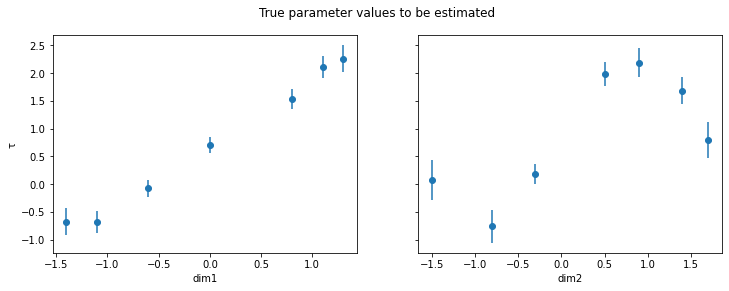

In [120]:
fig,axs = plt.subplots(1,2, figsize=(12,4), sharey=True)
axs[0].set_ylabel('τ')
axs[0].errorbar(x=dim1[:7], y=τ_top[:7], yerr=τ_top_σ[:7]*2, marker='o', ls='none')
axs[0].set_xlabel('dim1')
axs[1].errorbar(x=dim2[7:], y=τ_top[7:], yerr=τ_top_σ[7:]*2, marker='o', ls='none')
axs[1].set_xlabel('dim2');
plt.suptitle('True parameter values to be estimated');

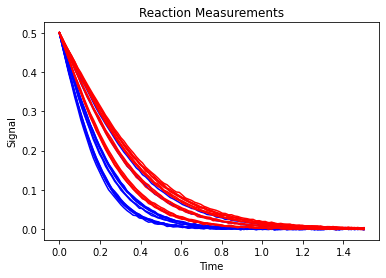

In [250]:
_, ax = plt.subplots(1, 1)
# From dim1 parameters
for idx,row in data.iterrows():
    if (idx < 7) | ((idx >= 14) & (idx < 21)):
        ax.plot(t, row.sig, color = 'blue')
ax.set_title('Reaction Measurements')
ax.set_xlabel('Time')
ax.set_ylabel('Signal');
# From dim2 parameters
for idx,row in data.iterrows():
    if ((idx >= 7) & (idx < 14)) | (idx >=21):
        ax.plot(t, row.sig, color = 'red')
ax.set_title('Reaction Measurements')
ax.set_xlabel('Time')
ax.set_ylabel('Signal');

In [114]:
S_obs = np.hstack(data.sig)
grp = data.group.values
n_grps = len(set(grp))
n_pts = data.sig.map(len)
rxn = np.hstack([int(i) * np.ones(n, dtype=int) for i,n in enumerate(n_pts)])
n_rxns = len(set(rxn))
t = np.hstack(data.time)

dim2_lst = np.sort(list(set(dim2)))[:,None]
dim2_idx = [list(dim2_lst).index(v) for v in dim2]
dim2_new = np.linspace(dim2_lst.min()-0.25, dim2_lst.max()+0.25,100)[:,None]
coord1 = theano.shared(dim1)
coord2 = theano.shared(dim2)

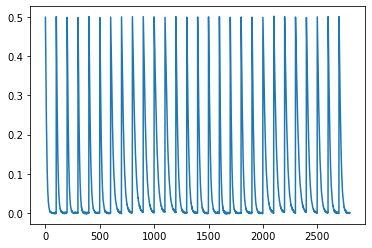

In [94]:
plt.plot(S_obs);

In [294]:
rxn.shape

(2800,)

In [ ]:
with pm.Model() as latent_model:
    τ_lgt_β_dim1 = pm.Normal('τ_lgt_β_dim1', mu=0, sigma=0.5)
    
    ℓ = pm.InverseGamma('ℓ', mu=1.7, sigma=0.5)
    η = pm.Gamma('η', alpha=2, beta=1)
    cov = η**2 * pm.gp.cov.ExpQuad(1, ℓ)
    
    gp = pm.gp.Latent(cov_func=cov)
    τ_lgt_β_dim2 = gp.prior('τ_lgt_β_dim2', X=dim2_lst)
    
    ## Group-level hyperpriors
    # Expected value of τ based on dim1 and dim2
    τ_lgt_μ_grp = pm.Deterministic('τ_lgt_μ_grp', τ_lgt_β_dim1*coord1 + τ_lgt_β_dim2[dim2_idx])
    # Non-centered parameterization of actual value of τ for each group
    τ_lgt_μ_grp_σ = pm.Exponential('τ_lgt_μ_grp_σ', lam=1)
    τ_lgt_μ_grp_nc = pm.Normal('τ_lgt_μ_grp_nc', mu=0, sigma=1, shape=n_grps)
    τ_lgt_μ = pm.Deterministic('τ_lgt_μ', τ_lgt_μ_grp_nc*τ_grp_μ_grp_σ+τ_lgt_μ_grp)
    
    # Non-centered parameterization of actual value of τ for each reaction
    τ_lgt_σ = pm.Exponential('τ_lgt_σ', lam=1)
    τ_lgt_z_nc = pm.Normal('τ_lgt_z_nc', mu=0, sigma=1, shape=n_rxns)
    τ_lgt_z = pm.Deterministic('τ_lgt_z', τ_lgt_z_nc*τ_lgt_σ + τ_lgt_μ[grp])
    τ_lgt = pm.Deterministic('τ_lgt', tau_lgt_z_nc*τ_lgt_σ+τ_lgt_μ[grp])
    # Un-transform τ back to the natural scale
    τ_lgt = pm.Deterministic('τ_lgt', τ_lgt_z*scale+shift)
    τ = pm.Deterministic('τ', pm.invlogit(τ_lgt))
                         
    σ = pm.Exponential('σ', lam=1)
    
    S = 1/(1+pm.math.exp(t/τ[rxn]))
    
    S_lik = pm.StudentT('S_lik', nu=3, mu=S, sigma=σ*np.exp(-7), observed=S_obs)                       

In [ ]:
with latent_model:
    trace = pm.sample(chains=2, random_seed=0, target_accept=0.95)

In [ ]:
with latent_model:
    τ_new = gp.conditional('τ_new', Xnew=dim2_new)

    gp_draws = pm.sample_posterior_predictive(trace, vars=[τ_new], samples=1000)

In [ ]:
summary = pm.summary(trace)
summary.sort_values('ess_mean')

In [ ]:
top_level_priors = ['ℓ','η','τ_lgt_β_dim1','τ_lgt_μ_grp_σ','τ_lgt_σ','σ']
pm.summary(trace[::2]).filter(top_level_priors,axis='index').sort_values('ess_mean')

In [ ]:
pm.plot_posterior(trace, var_names=top_level_priors);

In [ ]:
fig,axs = plt.subplots(1,2, figsize=(10,4), sharey=True)

for ax in axs:
    post = {stat: summary.filter(like= 'τ_lgt_μ[', axis='index').T.iloc[i].values for i,stat in enumerate(['m','e','l','u'])}
    x = dim2[6:]
    y = post['m'][6:]
    yerr = np.abs(y-np.stack([post['l'][6:],
                            post['u'][6:]]))
    ax.errorbar(x=x+0.025,y=y,yerr=yerr, ls='none', marker='o', color = 'C0', zorder=11);
    
    τ_lgt_β_dim2_prior = {
      'm': (trace['τ_lgt_β_dim2']).mean(axis=0),
      'e': (trace['τ_lgt_β_dim2']).std(axis=0),
      'l': np.percentile((trace['τ_lgt_β_dim2']),2.5,axis=0),
      'u': np.percentile((trace['τ_lgt_β_dim2']),97.5,axis=0),}
    x = dim2_lst
    y = τ_lgt_β_dim2_prior['m']
    e = τ_lgt_β_dim2_prior['e']
    yerr = np.abs(y-np.stack([τ_lgt_β_dim2_prior['l'],
                            τ_lgt_β_dim2_prior['u']]))
    ax.errorbar(x=x-0.025, y=y, yerr=yerr, ls='none', marker='o', color = 'k', mfc='w', zorder=10);
    ax.set_xlabel('dim2')

ax = axs[0]
pm.gp.util.plot_gp_dist(ax, trace['τ_lgt_β_dim2'], dim2_lst, palette='Oranges');
ax.set_title('Latent GP Retrodictions\nat observed values')
ax.set_ylabel('τ_lgt_β_dim2')

ax = axs[1]
notnan = np.isfinite(gp_draws['τ_new'][:,0])
print(f'{sum(~notnan)} non-finite draws')
pm.gp.util.plot_gp_dist(ax, gp_draws['τ_new'][notnan,:], dim2_new, palette='Oranges');
ax.set_title('Latent GP Predictions\nat new values');

plt.tight_layout();

# Marginal regression of a GP to the parameters estimation

In [302]:
y

NameError: name 'y' is not defined

In [ ]:
with pm.Model() as marginal_model:
    ℓ = pm.InverseGamma('ℓ', mu=1.7, sigma=0.5)
    η = pm.Gamma('η', alpha=2, beta=1)
    
    cov = η**2 * pm.gp.cov.ExpQuad(1, ℓ)
    gp = pm.gp.Marginal(cov_func=cov)
    
    grp_τ = gp.marginal_likelihood('grp_τ', X=x, y=y, noise=e)
    
    mp = pm.find_MAP()
    trace_marginal = pm.sample()